In [1]:
import numpy as np
import tensorflow as tf
from keras import backend as K

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model, Model
from keras.layers import concatenate, Activation, GlobalAveragePooling1D, GlobalMaxPooling1D, Layer, Dense, Embedding, LSTM, GRU, Dropout, SpatialDropout1D, Input, Average, Bidirectional, BatchNormalization
from keras.callbacks import Callback
from keras import initializers, regularizers, constraints, optimizers, layers

import sys, importlib
import utils
importlib.reload(sys.modules['utils'])

from keras.models import load_model
import json, argparse, os
import re
import io
import sys

Using TensorFlow backend.


Loading utils module
Loading utils module


In [2]:
# Don't hog GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
keras.backend.set_session(sess)

In [3]:
# Path to training and testing data file. This data can be downloaded from a link, details of which will be provided.
trainDataPath = "./train.txt"
testDataPath = "./dev.txt"
evalDataPath = "./test.txt"
# Output file that will be generated. This file can be directly submitted.
solutionPath = "./imdone.txt"

label2emotion = {0:"others", 1:"happy", 2: "sad", 3:"angry"}
emotion2label = {"others":0, "happy":1, "sad":2, "angry":3}

In [4]:
NUM_CLASSES = 4
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 35
EMBEDDING_DIM = 300

In [5]:
def preprocessData(dataFilePath, mode, total_raw=False):
    indices = []
    conversations = []
    raw_conversations = []
    labels = []
    
    import regex
    importlib.reload(sys.modules['regex'])
    
    with io.open(dataFilePath, encoding="utf8") as finput:
        finput.readline()
        for line in finput:
            raw_conv = ' '.join(line[:].strip().split('\t')[1:4])
            
            if not total_raw:
                repeatedChars = ['.', '?', '!', ',']
                for c in repeatedChars:
                    lineSplit = line.split(c)
                    while True:
                        try:
                            lineSplit.remove('')
                        except:
                            break
                    cSpace = ' ' + c + ' '    
                    line = cSpace.join(lineSplit)
            line = line.strip().split('\t')

            if mode == "train":
                # Train data contains id, 3 turns and label
                label = emotion2label[line[4]]
                labels.append(label)
            
            conv = ' <eos> '.join(line[1:4])
            
            # Remove any duplicate spaces
            duplicateSpacePattern = re.compile(r'\ +')
            conv = re.sub(duplicateSpacePattern, ' ', conv)
            
            indices.append(int(line[0]))
            # Remove stray punctuation
            if not total_raw:
                stray_punct = ['‑', '-', "^", ":",
                               ";", "#", ")", "(", "*", "=", "\\", "/"]
                for punct in stray_punct:
                        conv = conv.replace(punct, "")
    
            if not total_raw:
                processedData = regex.cleanText(conv.lower(), remEmojis=1).lower() #.rstrip()
                processedData = processedData.replace("'", "")
                # Remove numbers
                processedData = ''.join([i for i in processedData if not i.isdigit()])
            else:
                processedData = conv.lower()

            conversations.append(processedData)
            raw_conversations.append(raw_conv)
    
    if mode == "train":
        return indices, conversations, raw_conversations, labels
    else:
        return indices, conversations, raw_conversations

In [6]:
print("Processing test data...")
testIndices, testTexts, rawtestTexts, testLabels = preprocessData(testDataPath, mode="train", total_raw=True)
testLabels = to_categorical(np.asarray(testLabels), NUM_CLASSES)
print("Processing training data...")
trainIndices, trainTexts, rawtrainTexts, labels = preprocessData(trainDataPath, mode="train", total_raw=True)
labels = to_categorical(np.asarray(labels), NUM_CLASSES)
print("Processing evaluation data...")
evalIndices, evalTexts, rawevalTexts, evalLabels = preprocessData(evalDataPath, mode="train", total_raw=True)
evalLabels = to_categorical(np.asarray(evalLabels), NUM_CLASSES)

print("Extracting tokens...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token='<unk>')
# tokenizer.fit_on_texts(trainTexts)
tokenizer.fit_on_texts(trainTexts + testTexts + evalTexts)
trainSequences = tokenizer.texts_to_sequences(trainTexts)
testSequences = tokenizer.texts_to_sequences(testTexts)
evalSequences = tokenizer.texts_to_sequences(evalTexts)

wordIndex = tokenizer.word_index
print("Found %s unique tokens." % len(wordIndex))

Processing test data...
Loading utils module
Loading utils module
Processing training data...
Loading utils module
Processing evaluation data...
Loading utils module
Extracting tokens...
Found 19475 unique tokens.


In [7]:
lens = [len(x) for x in trainSequences]
print("Mean length for train data", np.mean((np.array(lens))))
print("Train-data Coverage (cutoff length):", np.sum(np.array(lens) <= MAX_SEQUENCE_LENGTH) / len(trainSequences))
print()
lens = [len(x) for x in testSequences]
print("Mean length for dev data", np.mean((np.array(lens))))
print("Dev-data Coverage (cutoff length):", np.sum(np.array(lens) <= MAX_SEQUENCE_LENGTH) / len(testSequences))
print()
lens = [len(x) for x in evalSequences]
print("Mean length for test data", np.mean((np.array(lens))))
print("Test-data Coverage (cutoff length):", np.sum(np.array(lens) <= MAX_SEQUENCE_LENGTH) / len(evalSequences))

Mean length for train data 15.655305039787798
Train-data Coverage (cutoff length): 0.9902851458885942

Mean length for dev data 14.97967332123412
Dev-data Coverage (cutoff length): 0.9927404718693285

Mean length for test data 14.979306589217645
Test-data Coverage (cutoff length): 0.9921945906698131


In [8]:
sorted_wordcounts = sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)
words_covered, total_words = 0, 0
for i, tup in enumerate(sorted_wordcounts):
    total_words += tup[1]
    if i < MAX_NB_WORDS:
        words_covered += tup[1]
print("Coverage with %d words:" % MAX_NB_WORDS, words_covered/total_words)

Coverage with 50000 words: 1.0


In [9]:
train_l, train_m, train_r = utils.split_into_three(trainTexts, tokenizer)
test_l, test_m, test_r = utils.split_into_three(testTexts, tokenizer)
eval_l, eval_m, eval_r = utils.split_into_three(evalTexts, tokenizer)

train_all = tokenizer.texts_to_sequences(trainTexts)
test_all = tokenizer.texts_to_sequences(testTexts)
eval_all = tokenizer.texts_to_sequences(evalTexts)

In [10]:
for i in range(5):
    print("Original:", testTexts[i])
    print("Processed:", rawtestTexts[i])
    print()

Original: then dont ask me <eos> youre a guy not as if you would understand <eos> im not a guy fuck off
Processed: Then dont ask me YOURE A GUY NOT AS IF YOU WOULD UNDERSTAND IM NOT A GUY FUCK OFF

Original: mixed things such as?? <eos> the things you do. <eos> have you seen minions??
Processed: Mixed things  such as?? the things you do. Have you seen minions??

Original: today i'm very happy <eos> and i'm happy for you ❤ <eos> i will be marry
Processed: Today I'm very happy and I'm happy for you ❤ I will be marry

Original: woah bring me some <eos> left it there oops <eos> brb
Processed: Woah bring me some left it there oops Brb

Original: it is thooooo <eos> i said soon master. <eos> he is pressuring me
Processed: it is thooooo I said soon master. he is pressuring me



In [11]:
importlib.reload(sys.modules['utils'])
print("Populating embedding matrix...")
embeddingMatrix, oov, oov_indices = utils.getEmbeddingMatrix(wordIndex, EMBEDDING_DIM)
oov = [(x, tokenizer.word_counts.get(x, 0)) for x in oov]
oov.sort(key=lambda tup: tup[1], reverse=True)

Loading utils module
Populating embedding matrix...
Found 400000 word vectors.
Found embedding for 63.0397946084724 % embeddings


In [12]:
importlib.reload(sys.modules['utils'])
print("Adding emoji embeddings...")
embeddingMatrix = utils.add_emoji_embedding(wordIndex, embeddingMatrix)

Loading utils module
Adding emoji embeddings...
Found embedding for 1.042362002567394 % embeddings


In [13]:
from tqdm import tqdm

def count_oov(texts):
    s, c = 0, 0
    for text in tqdm(texts):
        c += len(text)
        s += len(set(text).intersection(set(oov_indices)))
    return 100 * s/c

print("OOV with embedding vocabulary on train:", count_oov(trainSequences))
print("OOV with embedding vocabulary on dev:", count_oov(testSequences))
print("OOV with embedding vocabulary on test:", count_oov(evalSequences))

 17%|█▋        | 465/2755 [00:00<00:00, 2321.63it/s]

OOV with embedding vocabulary on train: 3.747850323192789


 10%|▉         | 543/5509 [00:00<00:01, 2712.36it/s]

OOV with embedding vocabulary on dev: 4.899561414136519


100%|██████████| 5509/5509 [00:02<00:00, 2606.13it/s]

OOV with embedding vocabulary on test: 4.907841640309739


In [14]:
import emoji

count_emoji_appearances = lambda texts: map(lambda x: len(set(emoji.UNICODE_EMOJI.keys()).intersection(set(x))) > 0, texts)

print("Sentences with emojis for train (%) :", 100 * np.mean(list(count_emoji_appearances(rawtrainTexts))))
print("Sentences with emojis for dev (%) :", 100 * np.mean(list(count_emoji_appearances(rawtestTexts))))
print("Sentences with emojis for test (%):", 100 * np.mean(list(count_emoji_appearances(rawevalTexts))))

Sentences with emojis for train (%) : 17.56631299734748
Sentences with emojis for dev (%) : 11.143375680580762
Sentences with emojis for test (%): 12.543111272463243


In [15]:
ooh = {}

relevant_oov = [x[0] for x in oov]
actual_words = [k for (k,v) in tokenizer.word_index.items()]
for datum in testTexts:
    words = datum.split(' ')
    for word in words:
        if word in relevant_oov :
            ooh[word] = ooh.get(word, 0) + 1

ooh_items = [(k, v) for (k,v) in ooh.items()]
ooh_items.sort(key=lambda tup: tup[1], reverse=True)

In [16]:
train_l = pad_sequences(train_l, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
train_m = pad_sequences(train_m, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
train_r = pad_sequences(train_r, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
train_all = pad_sequences(train_all, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

test_l = pad_sequences(test_l, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
test_m = pad_sequences(test_m, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
test_r = pad_sequences(test_r, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
test_all = pad_sequences(test_all, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

eval_l = pad_sequences(eval_l, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
eval_m = pad_sequences(eval_m, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
eval_r = pad_sequences(eval_r, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
eval_all = pad_sequences(eval_all, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print("Shape of training data tensor: ", train_l.shape)
print("Shape of training label tensor: ", labels.shape)

Shape of training data tensor:  (30160, 35)
Shape of training label tensor:  (30160, 4)


In [17]:
from keras.layers import average
from keras.regularizers import l1, l2, l1_l2
from keras.layers import RepeatVector
import keras.backend as K

from keras.constraints import MinMaxNorm
from keras.layers import Lambda

def buildSingleModel(embeddingMatrix, hidDim=128, maxlen=MAX_SEQUENCE_LENGTH, dp=0.25):
    embeddingLayer = Embedding(embeddingMatrix.shape[0],
                                    embeddingMatrix.shape[1],
                                    weights=[embeddingMatrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)
    
    inp = Input(shape=(maxlen,))
    x = embeddingLayer(inp)
    x = SpatialDropout1D(dp)(x)
    x = LSTM(hidDim, return_sequences=True, dropout=dp, recurrent_dropout=dp)(x)
    y = GRU(hidDim, return_sequences=True, dropout=dp, recurrent_dropout=dp)(x)
    
    att_x = utils.Attention(MAX_SEQUENCE_LENGTH)(x)
    mean_x = GlobalAveragePooling1D()(x)
    max_x = GlobalMaxPooling1D()(x)
    conc_x = concatenate([att_x, mean_x, max_x])
    conc_x = Dropout(dp)(conc_x)
    conc_x = Dense(hidDim, activation='relu')(conc_x)
    
    att_y = utils.Attention(MAX_SEQUENCE_LENGTH)(y)
    mean_y = GlobalAveragePooling1D()(y)
    max_y = GlobalMaxPooling1D()(y)
    conc_y = concatenate([att_y, mean_y, max_y])
    conc_y = Dropout(dp)(conc_y)
    conc_y = Dense(hidDim, activation='relu')(conc_y)
    
    conc = concatenate([conc_x, conc_y])
    conc = Dropout(dp)(conc)
    conc = Dense(hidDim, activation='relu')(conc)
    conc = Dropout(dp)(conc)
    output = Dense(NUM_CLASSES, activation='softmax')(conc)

    model = Model(inputs=inp, outputs=output)
    model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(1e-3),
                metrics=[utils.microF1Loss])

    return model

In [18]:
clr = utils.CyclicLR(base_lr=0.001, max_lr=0.005,
               step_size=300., mode='exp_range',
               gamma=0.99994)
model = buildSingleModel(embeddingMatrix, hidDim=32, dp=0.25)

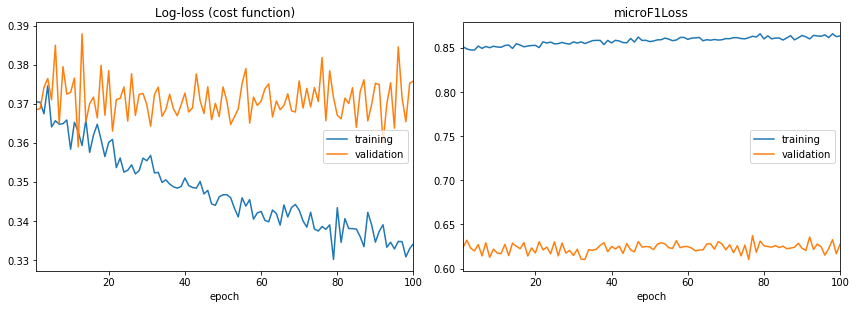

Log-loss (cost function):
training   (min:    0.330, max:    0.375, cur:    0.334)
validation (min:    0.359, max:    0.388, cur:    0.376)

microF1Loss:
training   (min:    0.847, max:    0.866, cur:    0.863)
validation (min:    0.610, max:    0.637, cur:    0.628)


In [22]:
from livelossplot.keras import PlotLossesCallback

model.fit(train_all, labels,
          batch_size=8192, epochs=100,
          callbacks=[PlotLossesCallback(), clr],
          verbose=0,
          validation_data=(test_all, testLabels))

In [27]:
predictions = model.predict(eval_all, batch_size=4096)
utils.getMetrics(predictions, evalLabels)

True Positives per class :  [4138.  197.  188.  238.]
False Positives per class :  [168. 191. 191. 198.]
False Negatives per class :  [539.  87.  62.  60.]
Class happy : Precision : 0.508, Recall : 0.694, F1 : 0.586
Class sad : Precision : 0.496, Recall : 0.752, F1 : 0.598
Class angry : Precision : 0.546, Recall : 0.799, F1 : 0.649
Ignoring the Others class, Macro Precision : 0.5165, Macro Recall : 0.7481, Macro F1 : 0.6111
Ignoring the Others class, Micro TP : 623, FP : 580, FN : 209
Accuracy : 0.8642, Micro Precision : 0.5179, Micro Recall : 0.7488, Micro F1 : 0.6123


(0.8642221818841895, 0.517872, 0.7487981, 0.612285032014763)

In [21]:
get_lstm_outputs = K.function([model.layers[0].input],
                                  [model.layers[2].output])
get_level1_outputs = K.function([model.layers[0].input],
                                  [model.layers[1].output])
for i in range(10):
    layer_output = get_lstm_outputs([train_all[:1][:,:5]])[0]
    lstm_weights = (model.layers[2].get_weights())
    print(np.max(lstm_weights[0]), np.min(lstm_weights[0]), np.mean(lstm_weights[0]))
    print(np.max(lstm_weights[1]), np.min(lstm_weights[1]), np.mean(lstm_weights[1]))
    print(np.max(lstm_weights[2]), np.min(lstm_weights[2]), np.mean(lstm_weights[2]))
    print(np.max(layer_output), np.min(layer_output), np.mean(layer_output))
    print()
    
    model.fit(train_all[:,:5], labels,
          batch_size=2048, epochs=1,
          verbose=1,
          validation_data=(test_all[:,:5], testLabels))

IndexError: list index out of range

In [ ]:
def construct_meta_features(data):
    # Compute emoji-based features
    emojis = ['😂', '😭', '😞', '😢', '😁', '😅', '😍',
              '😀', '😃', '😡', '😄', '😆', '😒', '😊',
              '😌', '😠', '😤', '🙂', '😺', '😫', '😩',
              '😹', '😜', '👍', '😘', '😸', '😉', '😽',
              '😻', '😏', '💔', '😝', '😑', '🙁', '😾',
              '😿', '😬', '❤', '😋', '🙄', '😔', '🙀',
              '😎', '👎', '😦', '😧', '❤️', '😛', '😶',
              '😐', '👌', '🤔','😇', '😨', '😯', '😳',
              '☹️', '💋', '👋', '😪', '😥', '💕', '😱',
              '🙈', '😟', '🙏', '✌', '😖', '😣', '😮',
              '🤗', '😓', '😷', '☹', '💞', '🏻', '🙌',
              '💐', '🙊', '😰', '☺', '😴', '🖕', '♥', '😕',
              '😈', '💗', '♡', '👀', '👊', '‑c', ' 8‑d', ' ‑d',
              '👻', '：）', '.', '?', '!', ',', '-', '・', "'-'",
              '\U0001f923','・ω・', '\U000fe339', ' ‑c']
    happy_words = ['happy', 'lol', 'haha', 'enjoy', 'cool', 'glad',
                   'smile', 'nice', 'funny', 'wow', 'good', 'best',
                   'party', 'baby', 'sweet', 'joke', 'glad', 'perfect',
                   'fantastic', 'excite', 'cute', 'enjoy', 'omg']
    angry_words = ['angry', 'fuck', 'hell', 'shut up', 'bad', 'rude',
                  'block', 'stupid', 'piss', 'lame', "don't", 'mean',
                  'irritat', 'hate', 'ignore', 'get lost', 'reply',
                  'fool', 'regret', 'dumb', 'cheat', 'whore', 'disgust']
    sad_words   = ['sad', 'sorry', 'miss', 'alone', 'lonely', 'cry',
                   'disappointed', 'not', 'no', 'not happy', 'crazy',
                   'stress', 'depress', 'poor', 'care', 'health', 'break up',
                   'breaking up', 'upset', 'forgive', 'left me', 'dump']
    others_words = ['thank you', 'favorite', 'favourite']
    indicator_words = emojis + happy_words + angry_words + sad_words + others_words
    
    word_features = np.zeros((len(data), len(indicator_words)))
    for i, text in enumerate(data):
        for j, word in enumerate(indicator_words):
            useful_text = text.lower()
#             useful_text = " ".join([text.split(' <eos> ')[0], text.split(' <eos> ')[-1]]).lower()
            word_features[i][j] += useful_text.count(word)
    
    # Compute CAPS-based features
    capital_features = np.zeros((len(data), 3))
    for i, text in enumerate(data):
        for word in text.split(' '):
            if word.isupper():
                capital_features[i][0] += 1
        capital_features[i][1] = capital_features[i][0] / (len(text.split(' ')) + 1)
        capital_features[i][2] = sum([len(x) for x in text.split(' ')]) / len(text.split(' '))
    
    # Combine metadata-based features
    metadata_features = np.concatenate((word_features, capital_features), axis=1)
    return metadata_features

In [ ]:
metadata_features = construct_meta_features(rawtrainTexts)
print(metadata_features.shape)

In [ ]:
# Train classifier for metadata-based classification
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score
meta_clf = tree.DecisionTreeClassifier()
meta_clf.fit(metadata_features, np.argmax(labels, axis=1))
utils.getMetrics(meta_clf.predict_proba(metadata_features), labels)

In [ ]:
predictions = model.predict(test_all, batch_size=1024)
eval_predictions = model.predict(eval_all, batch_size=1024)

In [ ]:
test_meta = construct_meta_features(rawtestTexts)
predictions_meta = meta_clf.predict_proba(test_meta)

eval_meta = construct_meta_features(rawevalTexts)
eval_predictions_meta = meta_clf.predict_proba(eval_meta)

In [ ]:
utils.getMetrics(predictions, testLabels)
print()
predictions_sly = np.copy(predictions)
eval_predictions_sly = np.copy(eval_predictions)

for i in range(len(predictions_sly)):
    if predictions_sly[i][1] >= 0.2:
        predictions_sly[i] = [0, 1, 0, 0]
#     if predictions_sly[i][0] >= 0.5:
#         predictions_sly[i] = [1, 0, 0, 0]
#     elif predictions_sly[i][1] >= 0.4:
#         predictions_sly[i] = [0, 1, 0, 0]
#     elif predictions_sly[i][2] >= 0.5:
#         predictions_sly[i] = [0, 0, 1, 0]
  
alpha = 0.8
# utils.getMetrics(predictions_sly, testLabels)
# print()
utils.getMetrics(alpha * predictions_sly + (1-alpha) * predictions_meta, testLabels)

In [ ]:
# predictions_towrite = (predictions).argmax(axis=1)
predictions_towrite = (alpha * predictions_sly + (1-alpha) * predictions_meta).argmax(axis=1)

with io.open(solutionPath, "w", encoding="utf8") as fout:
    fout.write('\t'.join(["id", "turn1", "turn2", "turn3", "label"]) + '\n')        
    with io.open(testDataPath, encoding="utf8") as fin:
        fin.readline()
        for lineNum, line in enumerate(fin):
            fout.write('\t'.join(line.strip().split('\t')[:4]) + '\t')
            fout.write(label2emotion[predictions_towrite[lineNum]] + '\n')
print("Completed")

In [ ]:
# predictions_towrite = (predictions).argmax(axis=1)
# evals_towrite = (alpha * eval_predictions_sly + (1-alpha) * eval_predictions_meta).argmax(axis=1)
evals_towrite = eval_predictions_sly.argmax(axis=1)

with io.open(solutionPath, "w", encoding="utf8") as fout:
    fout.write('\t'.join(["id", "turn1", "turn2", "turn3", "label"]) + '\n')        
    with io.open(evalDataPath, encoding="utf8") as fin:
        fin.readline()
        for lineNum, line in enumerate(fin):
            fout.write('\t'.join(line.strip().split('\t')[:4]) + '\t')
            fout.write(label2emotion[evals_towrite[lineNum]] + '\n')
print("Completed")